In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%env XLA_PYTHON_CLIENT_PREALLOCATE=false

env: XLA_PYTHON_CLIENT_PREALLOCATE=false


In [2]:
import sys
sys.path.append('../../')
import jax

jax.config.update("jax_platform_name", "cpu")

from sdebridge.setup import *

In [3]:
period = 2 * np.pi
sampling_rate = 2.0 * (1.0 / period)
num_grid = 16
z_grid = np.fft.rfftfreq(num_grid, d=1.0/sampling_rate)
print(z_grid)

[0.         0.01989437 0.03978874 0.0596831  0.07957747 0.09947184
 0.11936621 0.13926058 0.15915494]


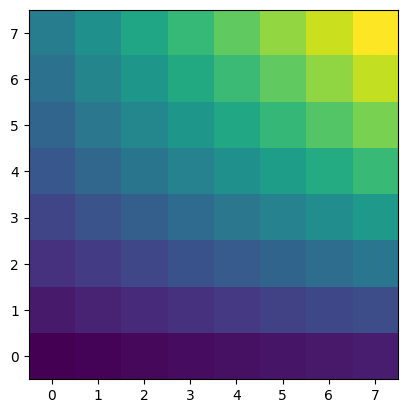

In [4]:
@partial(vmap, in_axes=(None, 0))
def X_tilde_z_col(X_tilde: jnp.ndarray, z: jnp.ndarray) -> jnp.ndarray:
    M = len(X_tilde)
    exponents = jnp.cos(jnp.arange(1, M+1) * z) + jnp.sin(jnp.arange(1, M+1) * z)
    return jnp.sum(X_tilde * exponents) + z

def gaussian_kernel(x1: ArrayLike, x2: ArrayLike, alpha: float = 1.0, sigma: float = 1.0) -> jnp.ndarray:
    return alpha * jnp.exp(-0.5 * (x1 - x2)**2 / sigma**2)

def Q_X(X_tilde: jnp.ndarray, z_grid: jnp.ndarray, alpha: float = 1.0, sigma: float = 1.0) -> jnp.ndarray:
    X_tilde_z_col_ = X_tilde_z_col(X_tilde, z_grid)
    N = len(z_grid)
    Q = jnp.empty((N, N), dtype=jnp.float32)
    for i in range(N):
        for j in range(N):
            Q = Q.at[i, j].set(gaussian_kernel(X_tilde_z_col_[i], z_grid[j], alpha, sigma))
    return Q

@partial(jit, static_argnums=(2, 3, 4, 5))
def diffusion(X_tilde: jnp.ndarray, 
              z_grid: jnp.ndarray, 
              alpha: float = 1.0, 
              sigma: float = 1.0,
              delta_z: float = 1e-2,
              period: float = 2 * jnp.pi):
    M = len(X_tilde)
    Q_X_ = Q_X(X_tilde, z_grid, alpha, sigma)
    exponent_basis1 = lambda i: delta_z * jnp.cos(i * z_grid) + jnp.sin(i * z_grid)
    exponent_basis2 = lambda i: delta_z * jnp.cos(-i * z_grid) + jnp.sin(-i * z_grid)
    inner_product = lambda i, j: exponent_basis1(i).T @ Q_X_ @ exponent_basis2(j) / period
    diffusion_matrix = vmap(vmap(inner_product, in_axes=(0, None)), in_axes=(None, 0))(jnp.arange(1, M+1), jnp.arange(1, M+1))
    return diffusion_matrix

X_tilde = jax.random.normal(GDRK, shape=(8,))
diffusion_ = diffusion(X_tilde, z_grid, alpha=1.0, sigma=0.5)
plt.imshow(jnp.abs(diffusion_), origin='lower')

In [5]:
from sdebridge.data_processing import sample_ellipse
from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.sde import CustomizedSDE
from sdebridge.utils import eval_score

2024-01-22 15:33:17.690025: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-22 15:33:17.690055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-22 15:33:17.691056: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-22 15:33:19.066369: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/gefan/miniconda3/envs/sdebridge/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonoteboo

In [6]:
def fourier_decompose(xs: jnp.ndarray, num_truncation: int = None) -> jnp.ndarray:
    num_samples = xs.shape[-1]
    coeffs = jnp.fft.rfft(xs, n=num_samples, norm='backward')
    if num_truncation is None:
        num_truncation = num_samples
    coeffs = coeffs[..., :num_truncation] / num_samples
    return coeffs

def fourier_reconstruct(coeffs: jnp.ndarray, num_samples: int = None) -> jnp.ndarray:
    if num_samples is None:
        num_samples = coeffs.shape[-1]
    coeffs = coeffs * num_samples
    return jnp.fft.irfft(coeffs, n=num_samples, norm='backward')

complex_to_real = lambda z: jnp.concatenate([z.real, z.imag], axis=0)
real_to_complex = lambda x: x[:len(x)//2] + 1j * x[len(x)//2:]

init_s shape:  (2, 256)
term_s shape:  (2, 256)


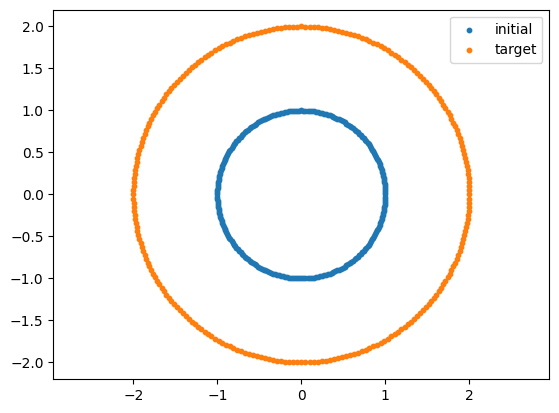

In [7]:
init_s = sample_ellipse(num_points=256, scale=1.0)
term_s = sample_ellipse(num_points=256, scale=2.0)
print("init_s shape: ", init_s.shape)
print("term_s shape: ", term_s.shape)
plt.scatter(init_s[0], init_s[1], s=10, label='initial')
plt.scatter(term_s[0], term_s[1], s=10, label='target')
plt.legend()
plt.axis('equal')
plt.show()

X shape: 
 (2, 256)
X coefficients (complex) shape: 
 (2, 8)
X (reconstructed) shape: 
 (2, 256)
XT (real represented) shape: 
 (2, 16)


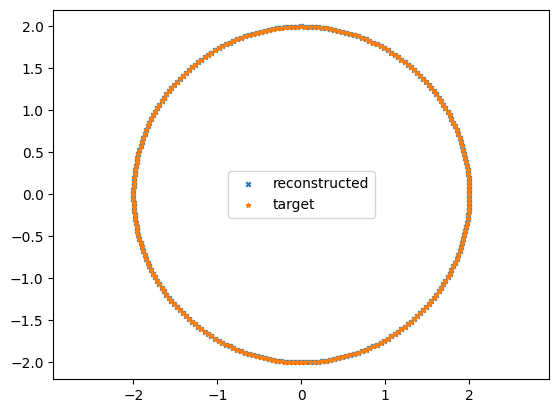

In [12]:
num_truncation = 8
num_samples = init_s.shape[-1]
period = 2.0 * jnp.pi
sampling_rate = 2.0 * (1.0 / period)
z_grid = jnp.fft.rfftfreq(num_truncation, d=1.0/sampling_rate)
X0 = jnp.zeros((4*num_truncation, ), dtype=jnp.float32)

displacement = term_s - init_s
print("X shape: \n", displacement.shape)
XT_complex = vmap(partial(fourier_decompose, num_truncation=num_truncation))(displacement)
print("X coefficients (complex) shape: \n", XT_complex.shape)
displacement_recon = vmap(partial(fourier_reconstruct, num_samples=num_samples))(XT_complex)
print("X (reconstructed) shape: \n", displacement_recon.shape)

XT = vmap(complex_to_real)(XT_complex)
print("XT (real represented) shape: \n", XT.shape)

term_s_recon = init_s + displacement_recon
plt.scatter(term_s_recon[0], term_s_recon[1], s=10, marker='x', label='reconstructed')
plt.scatter(term_s[0], term_s[1], s=10, marker='*', label='target')
plt.axis('equal')
plt.legend()

In [13]:
sde_config = ConfigDict()
sde_config.dim = 4*num_truncation
sde_config.N = 100
sde_config.T = 1.0
sde_config.drift = lambda val, time: jnp.zeros_like(val)
sde_config.diffusion = lambda val, time: diffusion(X_tilde=val, 
                                                   z_grid=z_grid, 
                                                   alpha=1.0, 
                                                   sigma=0.2,
                                                   delta_z=z_grid[1] - z_grid[0],
                                                   period=period)
sde_config.covariance = lambda val, time: sde_config.diffusion(val, time) @ sde_config.diffusion(val, time).T
sde = CustomizedSDE(sde_config)
bridge = DiffusionBridge(sde)
print(sde.config)

N: 100
T: 1.0
covariance: !!python/name:__main__.%3Clambda%3E ''
diffusion: !!python/name:__main__.%3Clambda%3E ''
dim: 32
drift: !!python/name:__main__.%3Clambda%3E ''



In [14]:
forward_uncond = bridge.simulate_forward_process(
    initial_val=X0,
    num_batches=1,
)

(1, 100, 2, 16)
(1, 100, 2, 8)
(1, 100, 2, 256)


/home/gefan/tmp/ipykernel_119511/2886069825.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('viridis', num_samples)(jnp.linspace(0, 1, num_samples))


(-11.071141576766967,
 11.881080961227417,
 -9.686872267723084,
 3.3446972608566283)

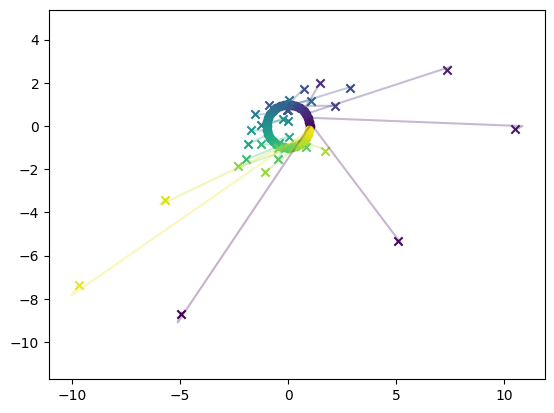

In [15]:
Xs = forward_uncond["trajectories"]
Xs = Xs.reshape((Xs.shape[0], 100, 2, -1))
print(Xs.shape)
coeffs = vmap(vmap(vmap(real_to_complex)))(Xs)
print(coeffs.shape)
displacements = vmap(vmap(vmap(partial(fourier_reconstruct, num_samples=num_samples))))(coeffs)
print(displacements.shape)

ss = displacements + init_s[None, None, :, :]
colors = plt.cm.get_cmap('viridis', num_samples)(jnp.linspace(0, 1, num_samples))
for i in jnp.arange(num_samples, step=8):
    plt.scatter(ss[0, 0, 0, i], ss[0, 0, 1, i], marker='o', color=colors[i])
    plt.plot(ss[0, :, 0, i], ss[0, :, 1, i], alpha=0.3, color=colors[i])
    plt.scatter(ss[0, -1, 0, i], ss[0, -1, 1, i], marker='x', color=colors[i])
plt.axis('equal')